# DATA -  RF - baseline 

   *Created: 2021.03.18 / Updated: 2022.02.20*
   
---

## IMPORTS

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import eli5
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
from pdpbox import pdp
import matplotlib.pyplot as plt

from pathlib import Path
from IPython.display import Image
from IPython.display import SVG #display, 
from eli5.sklearn import PermutationImportance

In [3]:
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import plot_partial_dependence

## GLOBAL PATH VARIABLES

In [4]:
# Notebook folder
NB_DIR = %pwd
NB_DIR = Path(NB_DIR)
# Root MCI foler
ROOT_DIR = NB_DIR.parent
# Main data folder (with downloaded csv files)
MAIN_DATA_DIR = ROOT_DIR/'data'
DATA_DIR_FS = ROOT_DIR / 'data_FS'
# Current data dir with sMCI_cAD.csv & bl.csv files
CURRENT_DATA_DIR = ROOT_DIR/'results'
# Results folder
RESULTS_DIR = ROOT_DIR/'results' #misclassified patient table
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
MODULES = ROOT_DIR/'modules'

## MCI MODULES

In [5]:
from pathlib import Path
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"/modules")

In [6]:
import mci_info as minfo
import mci_utils as mutils
import mci_rf_bl as mrfbl

#### INSTALLED PACKAGES INFO

In [7]:
if 1:
    packages = ['numpy', 'scipy', 'seaborn', 'pandas', 'matplotlib', 'statsmodels',
                'ipywidgets', 'eli5', 'pdpbox', 'sklearn']
    display(mutils.package_versions(installedOnly=False, theMostImportant=packages))



Computer name: Ingrids-MacBook-Air-3.local
Operating system: Darwin, 64bit

Python path: /Users/ingridrye/opt/miniconda3/envs/mciRF/bin/python
Python version: 3.7.10 (default, Feb 26 2021, 10:16:00) 
[Clang 10.0.0 ]



,module,version
4,eli5,0.11.0
6,ipywidgets,7.6.3
10,matplotlib,3.3.4
13,numpy,1.21.5
15,pandas,1.3.4
16,pdpbox,0.2.1
20,scipy,1.7.3
21,seaborn,0.11.2
23,sklearn,0.23.2
24,statsmodels,0.12.2


---

## GLOBAL VARIABLES TO UPDATE IN EACH NOTEBOOK SEPARATELY!!! 

In [8]:
# features to feed the current model
FEATURES = ['AGE','RAVLT_immediate', 'AVDEL30MIN_neuro', 'AVDELTOT_neuro',
            'TRAASCOR_neuro', 'TRABSCOR_neuro', 'CATANIMSC_neuro',
            'GDTOTAL_gds','ANARTERR_neuro', 'LRHHC_n_long', 'Apoe4_',
            'Subgroup_', 'Subgroup_num_', 'Usage_', 'PTGENDER',
            'Gender_num_'
               ]

FEATURE_NUMBER=len(FEATURES)
print(f'Number of selected features: {FEATURE_NUMBER}')

# Filename prefixes used to save all results (tables, images, ...)
FILE_NAME_PREFIX = '2.0-random_forest'
FILE_NAME_NUMBER = FILE_NAME_PREFIX.split('_')[0]

# Filename to load/save model. 
#Used if we load model from file with different name.
FILE_NAME_WITH_GS_MODEL_TO_LOAD = '2.0-random_forest'

# random state
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# folds 
FOLDS = 50

# cross-validation fold split number to save in a csv file
FOLDS_LIST = [10, 20, 50]

# display all stuff
VERBOSE = True

Number of selected features: 16


## LOAD `CSV BASELINE` FILE

Load baseline csv file and restrict the whole bunch of avaliable features to those defined in the variable `FEATURES` that is defined above.

In [9]:
bl_name = CURRENT_DATA_DIR / 'bl.csv'
bl_loaded = pd.read_csv(bl_name, index_col=0)

bl_sel_feat = bl_loaded[FEATURES]

print(f'Subjects: \t{bl_sel_feat.shape[0]}')
print(f'Columns: \t{bl_sel_feat.shape[1]}')

Subjects: 	708
Columns: 	16


In [10]:
bl_sel_feat.head()

,AGE,RAVLT_immediate,AVDEL30MIN_neuro,AVDELTOT_neuro,TRAASCOR_neuro,TRABSCOR_neuro,CATANIMSC_neuro,GDTOTAL_gds,ANARTERR_neuro,LRHHC_n_long,Apoe4_,Subgroup_,Subgroup_num_,Usage_,PTGENDER,Gender_num_
0,67.5,37.0,7.0,13.0,67.0,271.0,22.0,3.0,NaN,0.003966,0.0,sMCI,0,train,Male,0
6,80.4,30.0,1.0,7.0,49.0,168.0,13.0,0.0,17.0,0.003638,0.0,sMCI,0,test,Female,1
13,80.0,36.0,1.0,8.0,47.0,139.0,16.0,1.0,4.0,0.003458,0.0,cAD,1,train,Female,1
20,83.3,21.0,0.0,7.0,34.0,NaN,16.0,2.0,2.0,0.003313,0.0,sMCI,0,train,Male,0
26,76.8,27.0,5.0,10.0,61.0,300.0,19.0,4.0,23.0,0.005251,0.0,sMCI,0,train,Male,0


In [11]:
bl_sel_feat.columns

Index(['AGE', 'RAVLT_immediate', 'AVDEL30MIN_neuro', 'AVDELTOT_neuro',
       'TRAASCOR_neuro', 'TRABSCOR_neuro', 'CATANIMSC_neuro', 'GDTOTAL_gds',
       'ANARTERR_neuro', 'LRHHC_n_long', 'Apoe4_', 'Subgroup_',
       'Subgroup_num_', 'Usage_', 'PTGENDER', 'Gender_num_'],
      dtype='object')

#### DISPLAY THE NAN VALUES IN THE WHOLE DATA FRAME

Insepect `NaN` values in the loaded dataframe.

In [12]:
if VERBOSE:
    print(bl_sel_feat.isnull().sum())
    bl_sel_feat.shape

AGE                  0
RAVLT_immediate      0
AVDEL30MIN_neuro     0
AVDELTOT_neuro       1
TRAASCOR_neuro       0
TRABSCOR_neuro      10
CATANIMSC_neuro      0
GDTOTAL_gds          0
ANARTERR_neuro       6
LRHHC_n_long        14
Apoe4_               0
Subgroup_            0
Subgroup_num_        0
Usage_               0
PTGENDER             0
Gender_num_          0
dtype: int64


### SPLIT BETWEEN TRAIN AND TEST SUBSETS

In [13]:
bl_train = bl_sel_feat.loc[bl_sel_feat.Usage_ == 'train']
bl_test = bl_sel_feat.loc[bl_sel_feat.Usage_ == 'test']

# a list of both sets, to ease further manipulation
bl_sets = [['Train set', bl_train], ['Test set', bl_test]]

In [14]:
bl_train.head()

,AGE,RAVLT_immediate,AVDEL30MIN_neuro,AVDELTOT_neuro,TRAASCOR_neuro,TRABSCOR_neuro,CATANIMSC_neuro,GDTOTAL_gds,ANARTERR_neuro,LRHHC_n_long,Apoe4_,Subgroup_,Subgroup_num_,Usage_,PTGENDER,Gender_num_
0,67.5,37.0,7.0,13.0,67.0,271.0,22.0,3.0,NaN,0.003966,0.0,sMCI,0,train,Male,0
13,80.0,36.0,1.0,8.0,47.0,139.0,16.0,1.0,4.0,0.003458,0.0,cAD,1,train,Female,1
20,83.3,21.0,0.0,7.0,34.0,NaN,16.0,2.0,2.0,0.003313,0.0,sMCI,0,train,Male,0
26,76.8,27.0,5.0,10.0,61.0,300.0,19.0,4.0,23.0,0.005251,0.0,sMCI,0,train,Male,0
29,70.9,22.0,0.0,0.0,18.0,145.0,18.0,2.0,12.0,0.003026,1.0,cAD,1,train,Female,1


---

## TRAIN / TEST SETS SHORT INFO

In [15]:
if VERBOSE: 
    print('Subjects in:')
    for name, bl in bl_sets:
        print(f'\t{name}:\t{bl.shape[0]} ({bl.shape[0]/bl_sel_feat.shape[0] * 100:.0f}%)')

    print('\n\nSubjects in each subgroup (with NaN included):\n')
    for name, bl in bl_sets:
        print(f'*** {name} ***\n{bl.Subgroup_.value_counts().to_string()}\n')

Subjects in:
	Train set:	566 (80%)
	Test set:	142 (20%)


Subjects in each subgroup (with NaN included):

*** Train set ***
sMCI    305
cAD     261

*** Test set ***
sMCI    76
cAD     66



#### PRINT COLUMN NAMES INCLUDED IN BOTH SETS

In [16]:
minfo.included_feature_info(bl_train, pattern='adni-neuro-gds-long-_')

Total number of columns: 16



,adni (#3),neuro (#6),gds (#1),long (#1),ours (#5)
0,AGE,ANARTERR_neuro,GDTOTAL_gds,LRHHC_n_long,Apoe4_
1,PTGENDER,AVDEL30MIN_neuro,,,Gender_num_
2,RAVLT_immediate,AVDELTOT_neuro,,,Subgroup_
3,,CATANIMSC_neuro,,,Subgroup_num_
4,,TRAASCOR_neuro,,,Usage_
5,,TRABSCOR_neuro,,,


---

## COUNT `NaN` VALUES IN TRAIN AND TEST SETS

In [17]:
if VERBOSE:
    for name, bl in bl_sets:        
        print(f'*** NaN values in {name.upper()} set (out of {bl.shape[0]} rows) ***')
        print(bl.isnull().sum().to_string())
        print(f'\nRows in {name}: {bl.shape[0]}')
        print('\n\n')

*** NaN values in TRAIN SET set (out of 566 rows) ***
AGE                  0
RAVLT_immediate      0
AVDEL30MIN_neuro     0
AVDELTOT_neuro       1
TRAASCOR_neuro       0
TRABSCOR_neuro      10
CATANIMSC_neuro      0
GDTOTAL_gds          0
ANARTERR_neuro       4
LRHHC_n_long        13
Apoe4_               0
Subgroup_            0
Subgroup_num_        0
Usage_               0
PTGENDER             0
Gender_num_          0

Rows in Train set: 566



*** NaN values in TEST SET set (out of 142 rows) ***
AGE                 0
RAVLT_immediate     0
AVDEL30MIN_neuro    0
AVDELTOT_neuro      0
TRAASCOR_neuro      0
TRABSCOR_neuro      0
CATANIMSC_neuro     0
GDTOTAL_gds         0
ANARTERR_neuro      2
LRHHC_n_long        1
Apoe4_              0
Subgroup_           0
Subgroup_num_       0
Usage_              0
PTGENDER            0
Gender_num_         0

Rows in Test set: 142





#### DISPLAY ALL SUBJECTS THAT CONTAIN `NaN` VALUES (BOTH SETS)

In [18]:
if VERBOSE:
    for name, bl in bl_sets:
        num = bl.isnull().sum().sum()
        #idx = bl.isnull().index
        print(f'*** {name.upper()} ***')
        display(bl.loc[bl.isnull().any(axis=1)].head(num))
        print()

*** TRAIN SET ***


,AGE,RAVLT_immediate,AVDEL30MIN_neuro,AVDELTOT_neuro,TRAASCOR_neuro,TRABSCOR_neuro,CATANIMSC_neuro,GDTOTAL_gds,ANARTERR_neuro,LRHHC_n_long,Apoe4_,Subgroup_,Subgroup_num_,Usage_,PTGENDER,Gender_num_
0,67.5,37.0,7.0,13.0,67.0,271.0,22.0,3.0,NaN,0.003966,0.0,sMCI,0,train,Male,0
20,83.3,21.0,0.0,7.0,34.0,NaN,16.0,2.0,2.0,0.003313,0.0,sMCI,0,train,Male,0
2284,69.0,29.0,1.0,11.0,54.0,NaN,11.0,5.0,34.0,0.004512,1.0,sMCI,0,train,Female,1
2948,61.7,21.0,0.0,6.0,57.0,NaN,10.0,2.0,25.0,0.005170,1.0,sMCI,0,train,Male,0
3367,65.5,20.0,4.0,12.0,26.0,75.0,14.0,1.0,NaN,0.004289,0.0,sMCI,0,train,Male,0
3437,75.2,27.0,3.0,10.0,22.0,112.0,22.0,0.0,14.0,NaN,0.0,sMCI,0,train,Male,0
3523,81.6,28.0,3.0,10.0,61.0,170.0,14.0,0.0,24.0,NaN,1.0,sMCI,0,train,Male,0
3547,76.6,33.0,8.0,14.0,40.0,NaN,13.0,3.0,3.0,NaN,0.0,sMCI,0,train,Male,0
3639,66.7,55.0,11.0,14.0,33.0,NaN,28.0,3.0,1.0,0.005139,0.0,sMCI,0,train,Female,1
3652,71.0,20.0,0.0,8.0,60.0,176.0,20.0,1.0,24.0,NaN,1.0,sMCI,0,train,Female,1



*** TEST SET ***


,AGE,RAVLT_immediate,AVDEL30MIN_neuro,AVDELTOT_neuro,TRAASCOR_neuro,TRABSCOR_neuro,CATANIMSC_neuro,GDTOTAL_gds,ANARTERR_neuro,LRHHC_n_long,Apoe4_,Subgroup_,Subgroup_num_,Usage_,PTGENDER,Gender_num_
3926,63.0,32.0,5.0,15.0,35.0,105.0,21.0,2.0,7.0,NaN,1.0,sMCI,0,test,Male,0
6291,71.5,34.0,7.0,13.0,50.0,127.0,16.0,1.0,NaN,0.004996,0.0,sMCI,0,test,Male,0
6304,80.2,25.0,0.0,10.0,31.0,73.0,8.0,1.0,NaN,0.003878,0.0,cAD,1,test,Female,1


## DROP `NaN` VALUES IN TRAIN AND TEST SETS (IF ANY)

In [19]:
print('\nSubjects number in both sets AFTER dropping NaN values:\n')
for name, bl in bl_sets:        
    bl.dropna(axis='rows', inplace=True)
    print(f' - {name}: {bl.shape[0]}\n')


Subjects number in both sets AFTER dropping NaN values:

 - Train set: 539

 - Test set: 139



#### COUNT `NaN` VALUES IN TRAIN AND TEST SETS (AFTER DROP `NaN` ROWS) 

In [20]:
if VERBOSE:
    for name, bl in bl_sets:        
        print(f'*** NaN values in {name.upper()} set (out of {bl.shape[0]} rows) ***')
        print(bl.isnull().sum().to_string())
        print(f'\nRows in {name}: {bl.shape[0]}')
        print('\n\n')

*** NaN values in TRAIN SET set (out of 539 rows) ***
AGE                 0
RAVLT_immediate     0
AVDEL30MIN_neuro    0
AVDELTOT_neuro      0
TRAASCOR_neuro      0
TRABSCOR_neuro      0
CATANIMSC_neuro     0
GDTOTAL_gds         0
ANARTERR_neuro      0
LRHHC_n_long        0
Apoe4_              0
Subgroup_           0
Subgroup_num_       0
Usage_              0
PTGENDER            0
Gender_num_         0

Rows in Train set: 539



*** NaN values in TEST SET set (out of 139 rows) ***
AGE                 0
RAVLT_immediate     0
AVDEL30MIN_neuro    0
AVDELTOT_neuro      0
TRAASCOR_neuro      0
TRABSCOR_neuro      0
CATANIMSC_neuro     0
GDTOTAL_gds         0
ANARTERR_neuro      0
LRHHC_n_long        0
Apoe4_              0
Subgroup_           0
Subgroup_num_       0
Usage_              0
PTGENDER            0
Gender_num_         0

Rows in Test set: 139





___

#### COUNT TRAIN / TEST  PERCENTAGE PROPORTION AFTER EXCLUDING NaN VALUES

In [21]:
print('Subjects in:')
for name, bl in bl_sets:
    print(f'\t{name}:\t{bl.shape[0]} ({bl.shape[0]/(bl_train.shape[0] + bl_test.shape[0]) * 100:.0f}%)')

print('\n\nSubjects in each subgroup (without NaN included):\n')
for name, bl in bl_sets:
    #print(f'*** {name} ***\n')
    mutils.textWrap(name)
    print()
    #print(f'{bl.Subgroup_.value_counts().to_string()}\n')
    #print(f'{bl.PTGENDER.value_counts().to_string()}\n')
    
    dfs = bl.Subgroup_.value_counts().rename_axis('Subgroup_').reset_index(name='#Nr')
    dfp = bl.PTGENDER.value_counts().rename_axis('PTGENDER').reset_index(name='#Nr')
    df = pd.concat([dfs,dfp],axis=1)
    display(df)
    

    cols1 = ['AGE']
    cols2 = ['PTGENDER'] 
    df1 = bl.groupby(['Subgroup_', 'PTGENDER'])
    a = df1[cols1].mean().round(2)
    c = df1[cols1].std().round(2)
    b = df1[cols2].count()
    
    df_abc = pd.concat([a,c,b],axis=1) 
    display(df_abc)

Subjects in:
	Train set:	539 (79%)
	Test set:	139 (21%)


Subjects in each subgroup (without NaN included):


#################
### Train set ###
#################



,Subgroup_,#Nr,PTGENDER,#Nr
0,sMCI,283,Male,324
1,cAD,256,Female,215


AGE   AGE  PTGENDER
Subgroup_ PTGENDER                       
cAD       Female    72.43  7.33       100
          Male      74.87  6.57       156
sMCI      Female    72.36  7.42       115
          Male      73.81  7.51       168


################
### Test set ###
################



,Subgroup_,#Nr,PTGENDER,#Nr
0,sMCI,74,Male,82
1,cAD,65,Female,57


AGE   AGE  PTGENDER
Subgroup_ PTGENDER                       
cAD       Female    72.51  8.91        25
          Male      74.73  6.87        40
sMCI      Female    71.62  7.96        32
          Male      73.81  6.77        42

### SOME `SUBGROUP\_` STATISTICS

In [22]:
if VERBOSE:
    print('Basic statistics for features in both sets:')
    for name, bl in bl_sets:
        mutils.textWrap(name)
        print(f'\nSubjects {bl.shape[0]}')
        
        for gr in ['sMCI', 'cAD']:
            print(f'\n*** {gr} ***')
            display(minfo.df_stats_info(bl[bl.Subgroup_ == gr]))

Basic statistics for features in both sets:

#################
### Train set ###
#################

Subjects 539

*** sMCI ***


,max.,mean,min.,std,val_range,NaN_Nr
AGE,91.400,73.223,55.900,7.493,35.500,0
RAVLT_immediate,67.000,36.905,13.000,10.855,54.000,0
AVDEL30MIN_neuro,15.000,4.947,0.000,3.994,15.000,0
AVDELTOT_neuro,15.000,11.219,0.000,3.178,15.000,0
TRAASCOR_neuro,148.000,39.445,13.000,16.360,135.000,0
TRABSCOR_neuro,300.000,109.721,33.000,59.687,267.000,0
CATANIMSC_neuro,32.000,17.710,5.000,5.222,27.000,0
GDTOTAL_gds,6.000,1.678,0.000,1.473,6.000,0
ANARTERR_neuro,50.000,13.085,0.000,9.343,50.000,0
LRHHC_n_long,0.006,0.005,0.003,0.001,0.004,0



*** cAD ***


,max.,mean,min.,std,val_range,NaN_Nr
AGE,88.300,73.916,55.200,6.964,33.100,0
RAVLT_immediate,67.000,28.957,11.000,7.885,56.000,0
AVDEL30MIN_neuro,15.000,1.957,0.000,2.669,15.000,0
AVDELTOT_neuro,15.000,9.324,0.000,3.551,15.000,0
TRAASCOR_neuro,150.000,44.887,17.000,19.970,133.000,0
TRABSCOR_neuro,300.000,134.043,40.000,72.146,260.000,0
CATANIMSC_neuro,35.000,15.836,5.000,4.882,30.000,0
GDTOTAL_gds,6.000,1.707,0.000,1.424,6.000,0
ANARTERR_neuro,48.000,13.336,0.000,9.557,48.000,0
LRHHC_n_long,0.006,0.004,0.002,0.001,0.004,0



################
### Test set ###
################

Subjects 139

*** sMCI ***


,max.,mean,min.,std,val_range,NaN_Nr
AGE,87.800,72.861,57.800,7.340,30.000,0
RAVLT_immediate,65.000,36.838,20.000,9.223,45.000,0
AVDEL30MIN_neuro,14.000,4.622,0.000,3.670,14.000,0
AVDELTOT_neuro,15.000,11.405,1.000,3.114,14.000,0
TRAASCOR_neuro,87.000,38.149,16.000,12.059,71.000,0
TRABSCOR_neuro,283.000,101.892,54.000,44.779,229.000,0
CATANIMSC_neuro,30.000,18.176,6.000,5.005,24.000,0
GDTOTAL_gds,5.000,1.824,0.000,1.286,5.000,0
ANARTERR_neuro,43.000,11.973,0.000,9.223,43.000,0
LRHHC_n_long,0.007,0.004,0.003,0.001,0.004,0



*** cAD ***


,max.,mean,min.,std,val_range,NaN_Nr
AGE,88.400,73.875,55.000,7.729,33.400,0
RAVLT_immediate,50.000,30.800,20.000,6.911,30.000,0
AVDEL30MIN_neuro,11.000,2.400,0.000,2.656,11.000,0
AVDELTOT_neuro,15.000,9.785,2.000,3.586,13.000,0
TRAASCOR_neuro,150.000,44.200,21.000,26.764,129.000,0
TRABSCOR_neuro,300.000,132.785,38.000,81.064,262.000,0
CATANIMSC_neuro,28.000,15.877,6.000,4.204,22.000,0
GDTOTAL_gds,4.000,1.431,0.000,1.199,4.000,0
ANARTERR_neuro,44.000,13.169,0.000,10.080,44.000,0
LRHHC_n_long,0.006,0.004,0.003,0.001,0.003,0




---

# CREATE X AND y

In [23]:
# train set
X_train = bl_train.copy(deep=True)
y_train = X_train.Subgroup_num_

# test set
X_test = bl_test.copy(deep=True)
y_test = X_test.Subgroup_num_

# a list of both sets, to ease forfurther manipulation
X_sets = [['X train set', X_train], ['X test set', X_test]]
y_sets = [['y train set', y_train], ['y test set', y_test]]

In [24]:
print(X_test.shape)
print(X_train.shape)

(139, 16)
(539, 16)


# SAVING FILE WITH TEST / TRAIN SPLIT TO BE USED FOR PYCHARET MODEL

Saving file to be used in Pycaret-pipeline, were i) test/train split is defined by `Usage`-column, and ii) subjects with missing values are removed

In [25]:
pycaret = pd.concat([X_train, X_test])
print(pycaret.shape)
pycaret.head()

(678, 16)


,AGE,RAVLT_immediate,AVDEL30MIN_neuro,AVDELTOT_neuro,TRAASCOR_neuro,TRABSCOR_neuro,CATANIMSC_neuro,GDTOTAL_gds,ANARTERR_neuro,LRHHC_n_long,Apoe4_,Subgroup_,Subgroup_num_,Usage_,PTGENDER,Gender_num_
13,80.0,36.0,1.0,8.0,47.0,139.0,16.0,1.0,4.0,0.003458,0.0,cAD,1,train,Female,1
26,76.8,27.0,5.0,10.0,61.0,300.0,19.0,4.0,23.0,0.005251,0.0,sMCI,0,train,Male,0
29,70.9,22.0,0.0,0.0,18.0,145.0,18.0,2.0,12.0,0.003026,1.0,cAD,1,train,Female,1
37,72.8,29.0,1.0,8.0,40.0,101.0,17.0,1.0,6.0,0.002767,0.0,cAD,1,train,Male,0
55,77.6,30.0,2.0,14.0,150.0,300.0,12.0,0.0,9.0,0.002814,0.0,cAD,1,train,Male,0


In [26]:
train_test_csv_path = RESULTS_DIR / f'{FILE_NAME_PREFIX}_train_test.csv'
pycaret.to_csv(train_test_csv_path)

___

## Renaming features to get more intuitive features names on figures

In [27]:
# Remaing features 
new_names = ({"TRAASCOR_neuro":"TMTA",
              "TRABSCOR_neuro":"TMTB", 
              "Apoe4_":"APOE", "Gender_num_":"GENDER", 
              "CATANIMSC_neuro":"CFT",
              "GDTOTAL_gds":"GDS", 
              "LRHHC_n_long":"HC", 
              "ANARTERR_neuro":"ANART",
              "RAVLT_immediate":"RAVLT-Im", 
              "AVDEL30MIN_neuro":"RAVLT-Delay",
              "AVDELTOT_neuro":"RAVLT-Recog",
              "Subgroup_":"Subgroup_",
              "Subgroup_num_":"Subgroup_num_",
              "Usage_":"Usage_",
              "PTGENDER":"PTGENDER",
              "Gender_num_" : "GENDER"})

In [28]:
bl_sel_feat.rename(columns=new_names,
                      inplace=True)

# PREPARE `CROSS-VALIDATION` FOLDS FOR FUTURES USE (E.G. WITH LONGITUDINAL DATA)

### SAVE `CROSS-VALIDATION` FOLDS TO A `CSV` FILE

To have the same split rules for `bl` and `long` analysies we prepare a csv file with splits between `train` and `test` sets for varius k, e.g. for `k={10,20,50}`.

In [29]:
save_kfolds = 1

if save_kfolds:
    df2 = pd.DataFrame(index=X_train.index)
    
    for fld in FOLDS_LIST:
        # prefix: SKF_
        skf = StratifiedKFold(n_splits=fld, shuffle=False)
        SPLITS = []

        # a table for each fold separately (10...20...50)
        df = pd.DataFrame(index=X_train.index)
        
        
        for k, (train_index, validation_index) in enumerate(skf.split(X_train,y_train)):
        #     X_trainCV, X_validCV = X_train.iloc[train_index,:], X_train.iloc[validation_index,:]
        #     y_trainCV, y_validCV = y_train.iloc[train_index], y_train.iloc[validation_index]
            SPLITS.append([train_index, validation_index])
            
            col_name = f'SKF_CV{fld}_F{k:0>2}_'
            df.loc[X_train.index[validation_index], col_name] = "val"
            df.loc[X_train.index[train_index], col_name] = "train"
            
        # a table to concatenate tables with folds -> concat([df10, df20, df50])
        df2 = pd.concat([df2,df], axis=1)  
    
    # save to a file
    kfolds_csv_path = RESULTS_DIR / f'{FILE_NAME_PREFIX}_kfolds.csv'
    df2.to_csv(kfolds_csv_path)
    print(f'File saved to\n\t{kfolds_csv_path}')
    print()

File saved to
	/Users/ingridrye/Desktop/conversion_mci/results/2.0-random_forest_kfolds.csv



#### LOAD `CROSS-VALIDATION` FOLDS FROM FILE

In [30]:
kfolds_csv_path = RESULTS_DIR / f'{FILE_NAME_PREFIX}_kfolds.csv'
SPLITS = mutils.load_train_val_cv_splits_from_file(kfolds_csv_path, FOLDS)  

print(f"test\tval.\ttotal\n{25*'-'}")
for k in range(len(SPLITS)):
    #             #train, #val, #sum
    print(f'{len(SPLITS[k][0])}\t{len(SPLITS[k][1])}\t{len(SPLITS[k][0])+len(SPLITS[k][1])}')

test	val.	total
-------------------------
528	11	539
528	11	539
528	11	539
528	11	539
528	11	539
528	11	539
528	11	539
528	11	539
528	11	539
528	11	539
528	11	539
528	11	539
528	11	539
528	11	539
528	11	539
528	11	539
528	11	539
528	11	539
528	11	539
528	11	539
528	11	539
528	11	539
528	11	539
528	11	539
528	11	539
528	11	539
528	11	539
528	11	539
528	11	539
528	11	539
528	11	539
528	11	539
528	11	539
528	11	539
528	11	539
528	11	539
528	11	539
528	11	539
528	11	539
529	10	539
529	10	539
529	10	539
529	10	539
529	10	539
529	10	539
529	10	539
529	10	539
529	10	539
529	10	539
529	10	539


In [31]:
print(SPLITS[1])

[array([  0,   1,   2,   3,   4,   5,   6,   7,  10,  13,  14,  18,  19,
        20,  21,  22,  23,  25,  28,  29,  30,  32,  33,  34,  35,  36,
        37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,
        50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,
        63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
        76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
        89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
       102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
       115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,
       128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140,
       141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
       154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166,
       167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179,
       180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 1

---

# RANDOM FORESTS CLASSIFICATION

---

## REMOVE SELECTED COLUMNS FROM THE TRAIN & TEST SETS

In [32]:
print('From:')
for name, X in X_sets:
    print(f'\t{name}')
    
    for feat in ['Subgroup_', 'Subgroup_num_', 'Usage_', 'PTGENDER']:
        if feat in X.columns: X.drop(columns=feat,inplace=True); print(f'\t\tRemoved: {feat}')

From:
	X train set
		Removed: Subgroup_
		Removed: Subgroup_num_
		Removed: Usage_
		Removed: PTGENDER
	X test set
		Removed: Subgroup_
		Removed: Subgroup_num_
		Removed: Usage_
		Removed: PTGENDER


In [33]:
print('Column names in:\n')
for name, X in X_sets:
    print(f'- {name}:\n  {X.columns.to_list()}\n')

Column names in:

- X train set:
  ['AGE', 'RAVLT_immediate', 'AVDEL30MIN_neuro', 'AVDELTOT_neuro', 'TRAASCOR_neuro', 'TRABSCOR_neuro', 'CATANIMSC_neuro', 'GDTOTAL_gds', 'ANARTERR_neuro', 'LRHHC_n_long', 'Apoe4_', 'Gender_num_']

- X test set:
  ['AGE', 'RAVLT_immediate', 'AVDEL30MIN_neuro', 'AVDELTOT_neuro', 'TRAASCOR_neuro', 'TRABSCOR_neuro', 'CATANIMSC_neuro', 'GDTOTAL_gds', 'ANARTERR_neuro', 'LRHHC_n_long', 'Apoe4_', 'Gender_num_']



#### BASIC STATISTISC OF FEATURES IN TRAIN AND TEST SETS

In [34]:
if VERBOSE:
    print('Basic statistics for features in both sets:')
    for name, X in X_sets:
        print(f'\n{name} (Subjects {X.shape[0]}):')
        display(minfo.df_stats_info(X, precision=2))

Basic statistics for features in both sets:

X train set (Subjects 539):


,max.,mean,min.,std,val_range,NaN_Nr
AGE,91.40,73.55,55.2,7.25,36.2,0
RAVLT_immediate,67.00,33.13,11.0,10.34,56.0,0
AVDEL30MIN_neuro,15.00,3.53,0.0,3.74,15.0,0
AVDELTOT_neuro,15.00,10.32,0.0,3.49,15.0,0
TRAASCOR_neuro,150.00,42.03,13.0,18.35,137.0,0
TRABSCOR_neuro,300.00,121.27,33.0,66.95,267.0,0
CATANIMSC_neuro,35.00,16.82,5.0,5.14,30.0,0
GDTOTAL_gds,6.00,1.69,0.0,1.45,6.0,0
ANARTERR_neuro,50.00,13.20,0.0,9.44,50.0,0
LRHHC_n_long,0.01,0.00,0.0,0.00,0.0,0



X test set (Subjects 139):


,max.,mean,min.,std,val_range,NaN_Nr
AGE,88.40,73.34,55.0,7.51,33.4,0
RAVLT_immediate,65.00,34.01,20.0,8.73,45.0,0
AVDEL30MIN_neuro,14.00,3.58,0.0,3.41,14.0,0
AVDELTOT_neuro,15.00,10.65,1.0,3.43,14.0,0
TRAASCOR_neuro,150.00,40.98,16.0,20.45,134.0,0
TRABSCOR_neuro,300.00,116.34,38.0,65.94,262.0,0
CATANIMSC_neuro,30.00,17.10,6.0,4.77,24.0,0
GDTOTAL_gds,5.00,1.64,0.0,1.26,5.0,0
ANARTERR_neuro,44.00,12.53,0.0,9.62,44.0,0
LRHHC_n_long,0.01,0.00,0.0,0.00,0.0,0


---

# GRID SEARCH (PERFORM  OR LOAD)

In [39]:
# Run gridsearch (if 'grid_search = 1') and save the model to a file
# Load the best model from the file (if 'grid_search = 0')
grid_search = 0

# A filename of the the whole gridsearch structure
file_name_prefix_ext = FILE_NAME_WITH_GS_MODEL_TO_LOAD + '_GS_model.pkl'
file_name_prefix_path = RESULTS_DIR / file_name_prefix_ext

# define a stratification sheme
skf = StratifiedKFold(n_splits=FOLDS, shuffle=False)

if grid_search:       
    print("Searching the best RF's parameters...")
    rfcl = RandomForestClassifier(random_state=RANDOM_STATE)

    params = {"n_estimators": [40, 60, 70, 75, 80, 85, 90, 100, 120, 500, 1000, 10000],
              "max_depth": [3, 4, 5, 6],
              "max_features": [2, 3, 4, 5],
              "min_samples_split": [2, 3],
              "min_samples_leaf": [1, 2, 3],
              "bootstrap": [True, False],
              "criterion": ["gini", 'entropy']}    
    #params = {"n_estimators": [100, 373, 374, 375,1000, 10000]}
    
    grid = GridSearchCV(estimator=rfcl, param_grid=params, verbose=1, refit='accuracy', cv=skf, n_jobs=32, 
                       scoring = ['accuracy', 'f1', 'precision', 'recall'])
    
    # fit the best estimator to the train data
    grid.fit(X_train, y_train)
    
    # save best estimator to the file
    joblib.dump(grid, file_name_prefix_path)     
    print(f'Saved GridSearch object to: {file_name_prefix_path}')
else:
    print(f"GridSearch parameters loaded from a file:\n\t\t{file_name_prefix_path}")
    grid = joblib.load(file_name_prefix_path)     

    
clf = grid.best_estimator_

print()
print(f'Best score: {grid.best_score_:.3f}\n')

print(f'Best params:')
for k,v in grid.best_params_.items():
    print(f'\t{k}: {v}')
    
# save best params to a global variable
print('Best params are stored in BEST_PARAMS variable!')
BEST_PARAMS = grid.best_params_

GridSearch parameters loaded from a file:
		/Users/ingridrye/Desktop/conversion_mci/results/2.0-random_forest_GS_model.pkl

Best score: 0.746

Best params:
	bootstrap: True
	criterion: gini
	max_depth: 5
	max_features: 2
	min_samples_leaf: 1
	min_samples_split: 3
	n_estimators: 70
Best params are stored in BEST_PARAMS variable!


In [40]:
BEST_PARAMS

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 2,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 70}

___

# RANDOM FOREST PIPELINE WITH HYPERPARAMETERS ESTABLISHED IN GRID SEARCH

## CV50 SCORES (F1, ACCURACY, REACALL, PRECISION)

In [41]:
clf = RandomForestClassifier(random_state=RANDOM_STATE, **BEST_PARAMS)
scores_cv = cross_validate(clf, X_train, y_train, cv=SPLITS, scoring=['accuracy', 'f1', 'recall', 'precision'])

scores_cv_df = pd.DataFrame(scores_cv)
scores_cv_df = scores_cv_df[['test_accuracy', 'test_f1', 'test_recall', 'test_precision']]
scores_cv_df.rename(columns = {'test_accuracy': 'acc', 'test_f1':'f1',
                               'test_recall':'recall', 'test_precision':'prec'}, inplace=True)
display(scores_cv_df)

,acc,f1,recall,prec
0,0.727273,0.800000,1.000000,0.666667
1,0.727273,0.727273,0.666667,0.800000
2,0.454545,0.500000,0.500000,0.500000
3,0.909091,0.923077,1.000000,0.857143
4,0.727273,0.727273,0.666667,0.800000
5,0.545455,0.545455,0.500000,0.600000
6,0.909091,0.909091,1.000000,0.833333
7,0.636364,0.666667,0.800000,0.571429
8,0.636364,0.714286,1.000000,0.555556
9,0.727273,0.727273,0.800000,0.666667


### Mean score values for crossvalidation (k=50 folds):

In [42]:
prec = 2
score_all_folds_mean_df = pd.DataFrame.from_dict({'mean':scores_cv_df.mean().round(prec+2),
                                                  'std.':scores_cv_df.std().round(prec+1),
                                                  'min.':scores_cv_df.min().round(prec+2),
                                                  'max.':scores_cv_df.max().round(prec+2),
                                                  'range':scores_cv_df.values.ptp(axis=0).round(prec)})
display(score_all_folds_mean_df)

,mean,std.,min.,max.,range
acc,0.7460,0.163,0.3636,1.0,0.64
f1,0.7405,0.181,0.0000,1.0,1.00
recall,0.7827,0.223,0.0000,1.0,1.00
prec,0.7360,0.201,0.0000,1.0,1.00


----

In [43]:
clf = RandomForestClassifier(random_state=RANDOM_STATE, **BEST_PARAMS)


feat_import_CV = pd.DataFrame(index=X_train.columns, columns=list(range(FOLDS)))
conf_matrix_CV = np.zeros((FOLDS, 2 ,2))
valid_set_len_CV = np.ones(FOLDS)  # to calculate mean validation test lenght
bl_CV_pred_all = pd.DataFrame()


for k, (train_index, validation_index) in enumerate(SPLITS):
    X_trainCV, X_validCV = X_train.iloc[train_index,:], X_train.iloc[validation_index,:]
    y_trainCV, y_validCV = y_train.iloc[train_index], y_train.iloc[validation_index]
      
    # MODEL    
    # fit
    clf.fit(X_trainCV, y_trainCV)
    # predict
    y_predCV= clf.predict(X_validCV).reshape(-1,)
    
    # METRICS
    conf_matrix_CV[k, :, :]  = metrics.confusion_matrix(y_validCV, y_predCV)   
    
    # feature importance for all folds
    feat_import_CV[k] = clf.feature_importances_
    
    # CONFUSION MATRIX coefficients
    X_validCV_extended = mrfbl.confusion_matrix_coefficients_TPTNFPFN(X_validCV, y_validCV, y_predCV)
    
    # additional info about the current fold
    X_validCV_extended[f'CV{FOLDS}F_'] = k
    X_validCV_extended[f'CV{FOLDS}_Usage_'] = 'valid' 
    
    # df to agregate confusion-matrix-coefficients from all folds
    bl_CV_pred_all = pd.concat([bl_CV_pred_all, X_validCV_extended], axis=0)     
    
    # df with MISCLASSIFIED subjects in the current fold (k)
    err = X_validCV_extended.loc[(X_validCV_extended.y_true_ != X_validCV_extended.y_pred_)]
    print(f'fold: {k}, errors: {err.shape[0]}/{y_validCV.shape[0]}  ({err.shape[0]/y_validCV.shape[0]*100 :.1f}%)')
       
    # set current validation test set length
    valid_set_len_CV[k] = len(y_validCV)

fold: 0, errors: 3/11  (27.3%)
fold: 1, errors: 3/11  (27.3%)
fold: 2, errors: 6/11  (54.5%)
fold: 3, errors: 1/11  (9.1%)
fold: 4, errors: 3/11  (27.3%)
fold: 5, errors: 5/11  (45.5%)
fold: 6, errors: 1/11  (9.1%)
fold: 7, errors: 4/11  (36.4%)
fold: 8, errors: 4/11  (36.4%)
fold: 9, errors: 3/11  (27.3%)
fold: 10, errors: 6/11  (54.5%)
fold: 11, errors: 1/11  (9.1%)
fold: 12, errors: 3/11  (27.3%)
fold: 13, errors: 1/11  (9.1%)
fold: 14, errors: 1/11  (9.1%)
fold: 15, errors: 1/11  (9.1%)
fold: 16, errors: 5/11  (45.5%)
fold: 17, errors: 5/11  (45.5%)
fold: 18, errors: 1/11  (9.1%)
fold: 19, errors: 1/11  (9.1%)
fold: 20, errors: 0/11  (0.0%)
fold: 21, errors: 0/11  (0.0%)
fold: 22, errors: 2/11  (18.2%)
fold: 23, errors: 2/11  (18.2%)
fold: 24, errors: 1/11  (9.1%)
fold: 25, errors: 1/11  (9.1%)
fold: 26, errors: 4/11  (36.4%)
fold: 27, errors: 3/11  (27.3%)
fold: 28, errors: 1/11  (9.1%)
fold: 29, errors: 1/11  (9.1%)
fold: 30, errors: 2/11  (18.2%)
fold: 31, errors: 7/11  (63.6%)


#### LINK PREDICTION TABLE WITH OTHER SUBJECT FEATURES

Dataframe containing Random Forest model's predictions and all other subject features are being stored in a `csv` file in `results`-directory.

In [44]:
cols2 =[f'CV{FOLDS}F_',  f'CV{FOLDS}_Usage_'] 
filename = FILE_NAME_PREFIX + f'-CV{FOLDS}-predictions.csv'

bl_CV_pred_full = mrfbl.link_prediction_results_with_other_subject_features(bl_loaded, bl_CV_pred_all, cols2,
                                                                            filename, save=True, results_dir=RESULTS_DIR)


Subjects in the predictions table: 539

Predictions have been saved to a file:
		/Users/ingridrye/Desktop/conversion_mci/results/2.0-random_forest-CV50-predictions.csv


#### INTERACTIVE FOLDS INVESTIGATION (OPTIONAL)

In [45]:
if VERBOSE:
    cols = ['RID',  'y_true_', 'y_pred_', 'CM_pred_', f'CV{FOLDS}F_']
    minfo.iterate_patient_GUI(bl_CV_pred_full[cols], column=f'CV{FOLDS}F_')

---

# MODEL ANALYSIS & VISUALIZATION

----

## FEATURE IMPORTANCE (AVERAGE OUT OF 10 FOLDS)

In [46]:
feat_import_CV.reset_index(inplace=True)
feat_import_CV = feat_import_CV.rename({'index': 'feature'}, axis='columns')

#### FATURE IMPORTANCE IN EACH FOLD

In [47]:
if VERBOSE:
    display(feat_import_CV)

,feature,0,1,2,3,4,5,6,7,8,...,40,41,42,43,44,45,46,47,48,49
0,AGE,0.064303,0.068183,0.057930,0.062102,0.060319,0.060508,0.071751,0.057692,0.065159,...,0.068253,0.067463,0.067791,0.057479,0.061372,0.067907,0.067422,0.062185,0.062053,0.060012
1,RAVLT_immediate,0.210235,0.209178,0.201316,0.203161,0.212750,0.209772,0.200184,0.183152,0.200163,...,0.200216,0.209939,0.197414,0.211465,0.202102,0.188732,0.190542,0.182262,0.190909,0.187325
2,AVDEL30MIN_neuro,0.157467,0.161950,0.172076,0.160498,0.166956,0.164028,0.169454,0.179394,0.171044,...,0.163856,0.152787,0.171302,0.154524,0.159943,0.169715,0.164434,0.189510,0.162438,0.167420
3,AVDELTOT_neuro,0.072023,0.061461,0.056333,0.060574,0.062263,0.063640,0.070092,0.069659,0.059235,...,0.061098,0.074376,0.064988,0.073590,0.069789,0.063198,0.065135,0.069867,0.071777,0.066069
4,TRAASCOR_neuro,0.056260,0.054777,0.055799,0.057222,0.045650,0.049543,0.051316,0.066606,0.055021,...,0.047906,0.048948,0.047926,0.048016,0.053246,0.051923,0.050549,0.051076,0.054609,0.054749
5,TRABSCOR_neuro,0.074826,0.074411,0.074403,0.077675,0.075957,0.075313,0.078981,0.080533,0.087011,...,0.073352,0.069397,0.069958,0.077211,0.081375,0.074500,0.073408,0.075844,0.081661,0.080056
6,CATANIMSC_neuro,0.052735,0.056923,0.062453,0.056180,0.060062,0.050966,0.048668,0.051307,0.060144,...,0.049953,0.054153,0.048180,0.054181,0.048296,0.047320,0.051379,0.047111,0.050291,0.043536
7,GDTOTAL_gds,0.027862,0.027506,0.028191,0.029244,0.023863,0.025483,0.019208,0.024626,0.021915,...,0.024005,0.027952,0.024226,0.023746,0.023062,0.021696,0.019617,0.021468,0.021760,0.018768
8,ANARTERR_neuro,0.042021,0.045456,0.046852,0.042263,0.047234,0.047315,0.051468,0.046258,0.043075,...,0.054062,0.051560,0.052163,0.049851,0.051456,0.049746,0.051362,0.053890,0.050483,0.054452
9,LRHHC_n_long,0.188073,0.190115,0.195726,0.200090,0.188609,0.200071,0.182461,0.183939,0.177478,...,0.203306,0.188033,0.196514,0.197744,0.195654,0.203044,0.201644,0.189193,0.204859,0.217873


#### AVERAGE FEATURE IMPORTANCE OVER 10 FOLDS

In [48]:
feat_import_CV_stats = pd.DataFrame.from_dict({'feature':feat_import_CV.feature, 'mean':feat_import_CV.mean(axis=1).round(2), 'std.':feat_import_CV.std(axis=1).round(2)})
feat_import_CV_stats.sort_values(by='mean',ascending=False)

,feature,mean,std.
1,RAVLT_immediate,0.20,0.01
9,LRHHC_n_long,0.19,0.01
2,AVDEL30MIN_neuro,0.17,0.01
5,TRABSCOR_neuro,0.08,0.00
3,AVDELTOT_neuro,0.07,0.00
0,AGE,0.06,0.00
4,TRAASCOR_neuro,0.06,0.00
6,CATANIMSC_neuro,0.05,0.00
8,ANARTERR_neuro,0.05,0.00
10,Apoe4_,0.04,0.00


#### PLOT MEAN FEATURE IMPORTANCE FOR 10 FOLDS (OPTIONAL: SAVE, SIZE, ORIENTATION, ...)

Mean featue importacne plot saved to:
		/Users/ingridrye/Desktop/conversion_mci/results/figs/2.0-random_forest-CV50-feat-importance-h.png



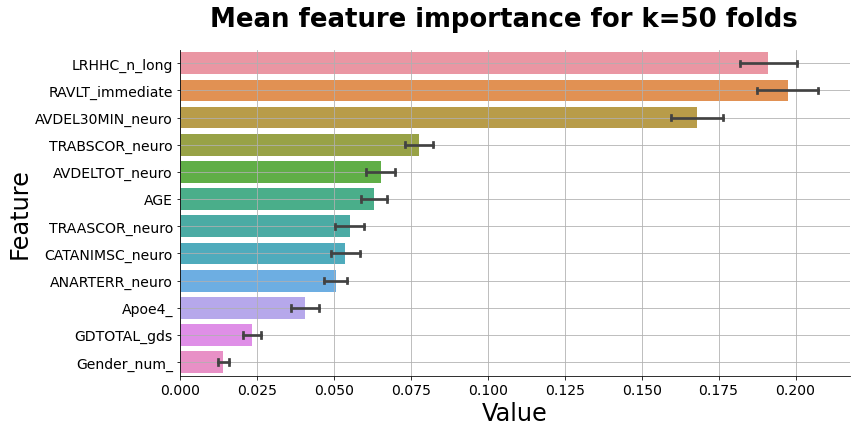

In [49]:
mrfbl.plot_mean_feature_importnce_cv(feat_import_CV, file_name_prefix=FILE_NAME_PREFIX,
                                     orientation='h',folds=FOLDS,figsize=(12,6), results_dir=RESULTS_DIR / 'figs', save=True)

---

## CONFUSION MATRIX

#### NUMBER OF SUBJECTS IN EACH FOLD

In [50]:
if VERBOSE:
    print(f'Subjects in each fold:\n\t{valid_set_len_CV}\n')
    print(f'Meand fold length: {valid_set_len_CV.mean()}')

Subjects in each fold:
	[11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11.
 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11.
 11. 11. 11. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]

Meand fold length: 10.78


#### PLOT CONFUSION MATRIX

Confusion matrix saved to:

		/Users/ingridrye/Desktop/conversion_mci/results/figs/2.0-random_forest-conf-matrix-CV50.png



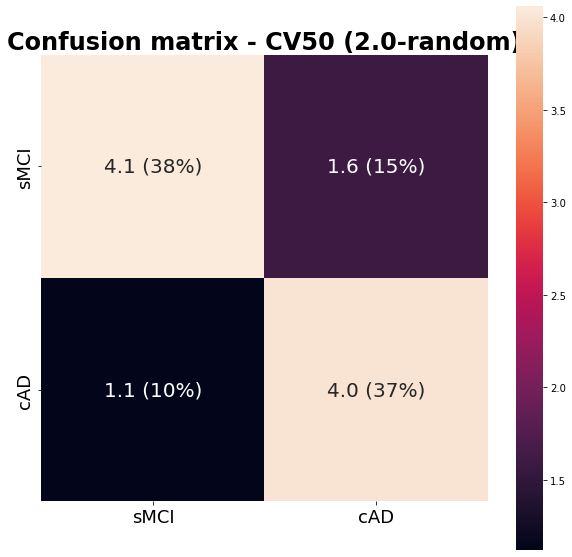

In [51]:
# mean of confusion matix over k=10 folds
conf_mat_mean = conf_matrix_CV.mean(axis=0)
# percantage values of confusion matix according to validatin set lenght
conf_mat_mean_prc = conf_mat_mean / valid_set_len_CV.mean() * 100

mrfbl.plot_confusion_matrix_CV(conf_mat_mean, conf_mat_mean_prc, folds=FOLDS, file_name_number=FILE_NAME_NUMBER,
                                file_name_prefix=FILE_NAME_PREFIX, result_dir=RESULTS_DIR/'figs', save=True)

---

# TEST SET

---

#### TEST SETS VISUAL INSPECTIONS (OPTIONAL)

In [52]:
if VERBOSE:    
    tmp_df = pd.DataFrame.from_dict({'X_test_mean':X_test.mean().round(2), 'X_test_std':X_test.std().round(2)})
    
    print('"Original" Test set ')
    display(X_test.head())
    print('\nMean and std comparison')
    display(tmp_df)

"Original" Test set 


,AGE,RAVLT_immediate,AVDEL30MIN_neuro,AVDELTOT_neuro,TRAASCOR_neuro,TRABSCOR_neuro,CATANIMSC_neuro,GDTOTAL_gds,ANARTERR_neuro,LRHHC_n_long,Apoe4_,Gender_num_
6,80.4,30.0,1.0,7.0,49.0,168.0,13.0,0.0,17.0,0.003638,0.0,1
82,77.3,29.0,0.0,11.0,122.0,151.0,17.0,2.0,3.0,0.003343,1.0,0
184,77.5,35.0,1.0,10.0,27.0,69.0,24.0,2.0,22.0,0.003149,1.0,1
359,71.1,24.0,0.0,2.0,50.0,85.0,13.0,2.0,7.0,0.003729,0.0,1
384,83.6,30.0,2.0,9.0,22.0,76.0,18.0,0.0,9.0,0.003700,0.0,1



Mean and std comparison


,X_test_mean,X_test_std
AGE,73.34,7.51
RAVLT_immediate,34.01,8.73
AVDEL30MIN_neuro,3.58,3.41
AVDELTOT_neuro,10.65,3.43
TRAASCOR_neuro,40.98,20.45
TRABSCOR_neuro,116.34,65.94
CATANIMSC_neuro,17.10,4.77
GDTOTAL_gds,1.64,1.26
ANARTERR_neuro,12.53,9.62
LRHHC_n_long,0.00,0.00


---

## PREDICT SUBGROPUS IN THE UNSEEN TEST SET

In [53]:
clf = RandomForestClassifier(random_state=RANDOM_STATE, **BEST_PARAMS)
clf.fit(X_train, y_train)

y_test_pred = clf.predict(X_test)

#compare two ways of accuracy calucation
if VERBOSE:
    print(metrics.accuracy_score(y_test, y_test_pred).round(3))
    print(clf.score(X_test, y_test).round(3))

0.662
0.662


## TEST SET SCORES (F1, ACCURACY, RECALL, PRECISION)

In [54]:
# metrics
f1 = metrics.f1_score(y_test, y_test_pred)
acc = metrics.accuracy_score(y_test, y_test_pred)
recall = metrics.recall_score(y_test, y_test_pred)
prec = metrics.precision_score(y_test, y_test_pred)

print(f'F1: {f1:.3f}')
print(f'ACC: {acc:.3f}')
print(f'RECALL: {recall:.3f}')
print(f'PREC: {prec:.3f}')

F1: 0.630
ACC: 0.662
RECALL: 0.615
PREC: 0.645


## CONUSIOM MATRIX

#### PREDICTIONS

In [55]:
bl_test_pred = mrfbl.confusion_matrix_coefficients_TPTNFPFN(X_test, y_test, y_test_pred)

cols2= []
filename = FILE_NAME_PREFIX + f'-TEST-predictions.csv'
bl_test_pred_full = mrfbl.link_prediction_results_with_other_subject_features(bl_loaded, bl_test_pred, cols2, filename,
                                                                              save=True, results_dir=RESULTS_DIR)


Subjects in the predictions table: 139

Predictions have been saved to a file:
		/Users/ingridrye/Desktop/conversion_mci/results/2.0-random_forest-TEST-predictions.csv


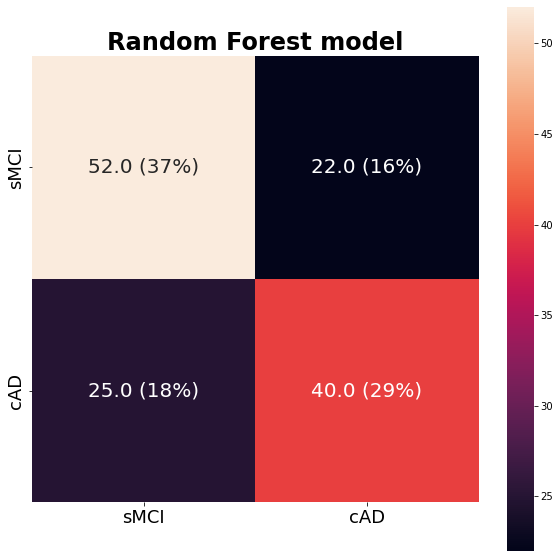

In [56]:
conf_matrix_test  = metrics.confusion_matrix(y_test, y_test_pred)    

# mean of test confusion matix
conf_mat_mean = conf_matrix_test.mean(axis=0)
# percantage values of confusion matix according to validatin set lenght
conf_matrix_test_prc = conf_matrix_test / y_test.shape[0] * 100


mrfbl.plot_confusion_matrix_TEST_IR(conf_matrix_test, conf_matrix_test_prc, file_name_number="K50"+FILE_NAME_NUMBER, title = "Random Forest model", file_name_prefix=FILE_NAME_PREFIX,
                                 save=True, results_dir=RESULTS_DIR/'figs')

## FEATURE IMPORTANCE

In [57]:
feature_imp = pd.Series(clf.feature_importances_,index=X_train.columns).sort_values(ascending=False)
print(f'Feature importance for the train set:\n\n{feature_imp.to_string()}')

Feature importance for the train set:

LRHHC_n_long        0.208739
RAVLT_immediate     0.187059
AVDEL30MIN_neuro    0.162150
TRABSCOR_neuro      0.078708
AVDELTOT_neuro      0.075343
AGE                 0.066962
TRAASCOR_neuro      0.052947
ANARTERR_neuro      0.050707
CATANIMSC_neuro     0.047168
Apoe4_              0.036140
GDTOTAL_gds         0.018221
Gender_num_         0.015856


Mean featue importacne plot saved to:
		/Users/ingridrye/Desktop/conversion_mci/results/figs/2.0-random_forest-TEST-feat-importance-h.png



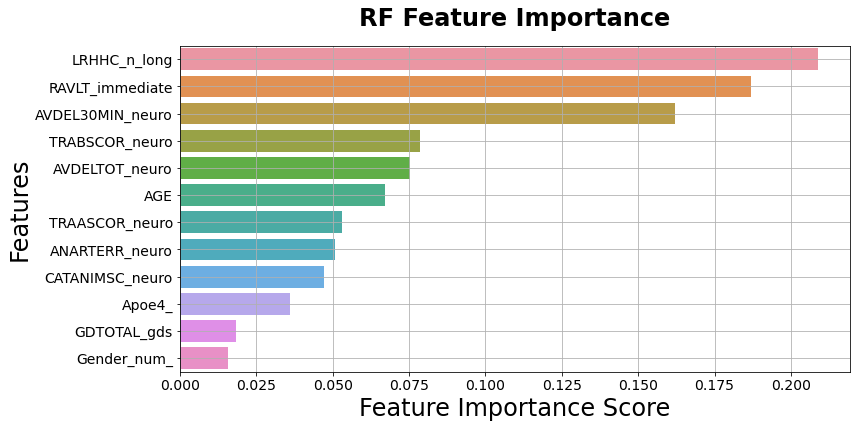

In [58]:
mrfbl.plot_single_feature_importnce(feature_imp,
                                    FILE_NAME_PREFIX, orientation='h', figsize=(12,6), results_dir = RESULTS_DIR/'figs')

---

# FEATURE PERMUTATION WITH `eli5` 
Documentation to be found on: https://eli5.readthedocs.io/en/latest/blackbox/permutation_importance.html

In [59]:
clf = RandomForestClassifier(random_state=RANDOM_STATE, **BEST_PARAMS)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, max_features=2, min_samples_split=3,
                       n_estimators=70, random_state=42)

## TEST SET

In [60]:
perm = PermutationImportance(clf, random_state=RANDOM_STATE).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist(),)

Weight,Feature
0.0403 ± 0.0503,LRHHC_n_long
0.0245 ± 0.0413,RAVLT_immediate
0.0086 ± 0.0108,AGE
0.0058 ± 0.0141,CATANIMSC_neuro
0.0000 ± 0.0129,Gender_num_
-0.0014 ± 0.0211,Apoe4_
-0.0014 ± 0.0058,GDTOTAL_gds
-0.0029 ± 0.0503,AVDEL30MIN_neuro
-0.0058 ± 0.0168,TRAASCOR_neuro
-0.0101 ± 0.0147,TRABSCOR_neuro


---